In [8]:
import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from utils import cmap, readAllData, readJson, show
import matplotlib.pyplot as plt

# Primitive

- pixel graph: pixel != 0
- line graph:  

# Goal
Let the model learn higher level idea without supervision. One such idea is a square graph.
Create a lookup table with 
- key = hash of graph unique property
- value = the graph itself

>[!NOTE]
> graph = node (for generalization)

In [9]:
data = readAllData('./data/idea_testing/')
data = data[0]['train']['input']
len(data)

10

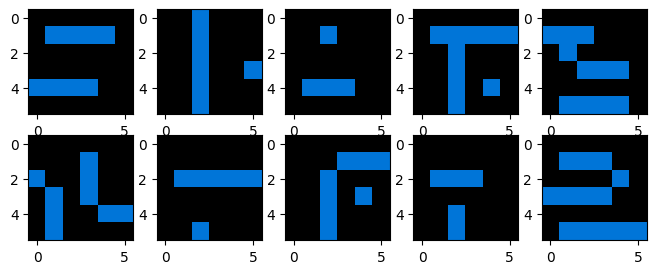

In [10]:
rows, cols = 2, 5 
_, ax = plt.subplots(rows, cols, figsize=(8, 3))

for c in range(cols):
    for r in range(rows):
        show(data[c * 2 + r], ax[r, c])

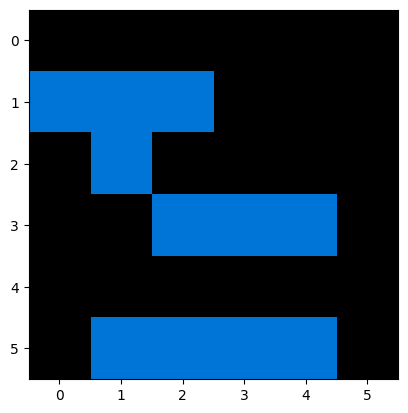

In [94]:
img = t.tensor(data[8], dtype=t.float32).unsqueeze(0).unsqueeze(0)
show(img.squeeze(0).squeeze(0))

In [95]:
kernals = t.tensor([[
    [[-1],
     [1]],
]], dtype=t.float32)

In [96]:
filtered_imgs = F.conv2d(img, kernals, padding=1)

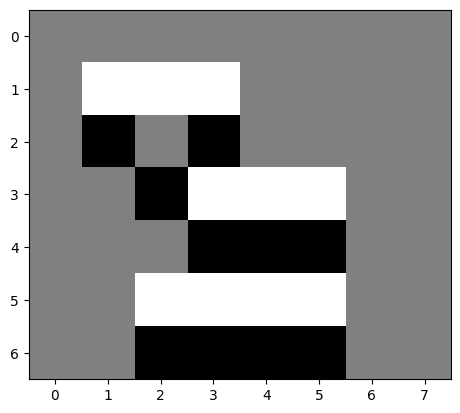

In [97]:
plt.imshow(filtered_imgs.squeeze(0).squeeze(0), cmap='gray')

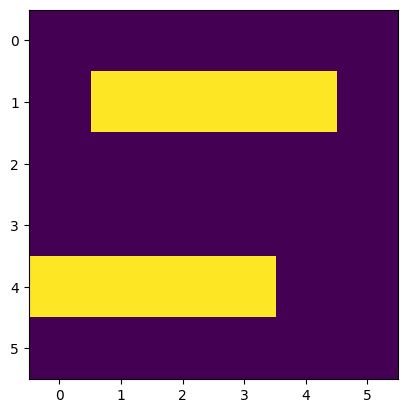

In [53]:
img = data[0]
rows, cols = img.shape
plt.imshow(img)

In [91]:
class Node:
    def __init__(self, row, col, color):
        self.row = row
        self.col = col
        self.color = color
        self.is_visited = False

    def __str__(self):
        return f'Node({self.row}, {self.col}, {self.color})'
    
    def __repr__(self):
        return self.__str__()
    
    def getLocations(self):
        return [(self.row, self.col)]

class Pixel(Node):
    def __init__(self, row, col, color):
        super().__init__(row, col, color)

    def __str__(self):
        return f'Pixel({self.row}, {self.col}, {self.color})'
    
    def __repr__(self):
        return self.__str__()

class Grid:
    def __init__(self, rows, cols, graphs=None):
        self.rows = rows
        self.cols = cols
        self.grid = [[None for _ in range(cols)] for _ in range(rows)]

        self.graphs = graphs
        if graphs == None: return
        for graph in graphs:
            for r, c in graph.getLocations():
                self.grid[r][c] = graph

    def getNodes(self, row, col):
        if row < 0 or row >= self.rows or col < 0 or col >= self.cols:
            return None
        return self.grid[row][col]
    
    def setNode(self, row, col, Node):
        self.grid[row][col] = Node

    def resetVisited(self):
        for row in self.grid:
            for node in row:
                node.is_visited = False

    def __str__(self):
        s = ''
        for row in self.grid:
            for node in row:
                s += f'{node} '
            s += '\n'
        return s
    
    def __repr__(self):
        return self.__str__()

In [94]:
def makePixelsFromImage(img):
    pixels = []
    rows, cols = img.shape
    for r in range(rows):
        for c in range(cols):
            if img[r, c] > 0:
                pixel = Pixel(r, c, img[r, c])
                pixels.append(pixel)
    return pixels
            
pixels_grid = Grid(rows, cols, makePixelsFromImage(img))
print("pixels: ")
print(pixels)
print()
print("grid: ")
print(pixels_grid)

pixels: 
[Pixel(1, 1, 1), Pixel(1, 2, 1), Pixel(1, 3, 1), Pixel(1, 4, 1), Pixel(4, 0, 1), Pixel(4, 1, 1), Pixel(4, 2, 1), Pixel(4, 3, 1)]

grid: 
None None None None None None 
None Pixel(1, 1, 1) Pixel(1, 2, 1) Pixel(1, 3, 1) Pixel(1, 4, 1) None 
None None None None None None 
None None None None None None 
Pixel(4, 0, 1) Pixel(4, 1, 1) Pixel(4, 2, 1) Pixel(4, 3, 1) None None 
None None None None None None 



In [95]:
class Line(Node):
    def __init__(self, row, col, pixels):
        super().__init__(row, col, pixels[0].color)
        self.pixels = pixels

    def getLocations(self):
        return [pixel.getLocation() for pixel in self.pixels]

    def __str__(self):
        return f'Line({self.row}, {self.col})'
    
    def __repr__(self):
        return self.__str__()


In [56]:
class RefNode:
    def __init__(self, node: Node):
        self.ref = node
        self.adjacent = []

In [77]:
layer0_pixels = Grid.makeLayer0FromImage(img)

In [78]:
layer1_horizontal_lines = Grid(rows, cols)
layer1_vertical_lines = Grid(rows, cols)

In [80]:
def makeHLine(layer, r, c):
    layer.is_visited = True
    node = layer.getNode(r, c)

    graph = RefNode(node)
    right_graph = None
    left_graph = None

    right_node = layer.getNode(r, c + 1)
    if right_node != None \
    and not right_node.is_visited \
    and right_node.color == node.color:
        right_graph = makeHLine(layer, r, c + 1)

    left_node = layer.getNode(r, c - 1)
    if left_node != None \
    and not left_node.is_visited \
    and left_node.color == node.color:
        left_graph = makeHLine(layer, r, c - 1)
    
    if right_graph != None:
        right_graph.adjacent.append(node)
        node.adjacent.append(right_graph)

    if left_graph != None:
        left_graph.adjacent.append(node)
        node.adjacent.append(left_graph)

    if right_graph == None and left_graph == None:
        return None
    else:
        return graph

In [81]:
def makeHLineLayer(layer):
    layer.resetVisited()
    for r in range(layer.rows):
        for c in range(layer.cols):
            node = layer.getNode(r, c)
            if node == None \
            or node.is_visited: 
                continue

            makeHLine(layer, r, c)

In [ ]:
makeHLineLayer(layer1_horizontal_lines)